In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import rpy2.robjects as robjects
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, vectors

from rich.console import Console
from rich.table import Table

import DataExtractor
import datetime

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, acorr_ljungbox
from scipy.stats import kurtosis, shapiro, kstest, norm

import warnings
warnings.filterwarnings('ignore')

In [52]:
%%capture
r = robjects.r
r['source']('./R/R_Imports.R')

* installing *source* package ‘strucchange’ ...
** pacchetto ‘strucchange’ aperto con successo con controllo somme MD5
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (Anaconda gcc) 11.2.0’


x86_64-conda-linux-gnu-cc -I"/home/simone/miniconda3/envs/MPSMF_ENV/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/simone/miniconda3/envs/MPSMF_ENV/include -I/home/simone/miniconda3/envs/MPSMF_ENV/include -Wl,-rpath-link,/home/simone/miniconda3/envs/MPSMF_ENV/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/simone/miniconda3/envs/MPSMF_ENV/include -fdebug-prefix-map=/workspace/croot/r-base_1695428141831/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/home/simone/miniconda3/envs/MPSMF_ENV=/usr/local/src/conda-prefix  -c strucchange_functions.c -o strucchange_functions.o
x86_64-conda-linux-gnu-cc -I"/home/simone/miniconda3/envs/MPSMF_ENV/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/simone/miniconda3/envs/MPSMF_ENV/include -I/home/simone/miniconda3/envs/MPSMF_ENV/include -Wl,-rpath-link,/home/simone/miniconda3/envs/MPSMF_ENV/lib

installing to /home/simone/miniconda3/envs/MPSMF_ENV/lib/R/library/00LOCK-strucchange/00new/strucchange/libs
** R
** data
*** moving datasets to lazyload DB
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (strucchange)
* installing *source* package ‘SupMZ’ ...
** pacchetto ‘SupMZ’ aperto con successo con controllo somme MD5
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if

# Analisi Fianziaria di Criptovalute

# 0. Analisi del Mercato

# 1. Estrazione dei Dati
I dati sono stati estratti dal sito *Yahoo Finance* usando delle REST API. I dati sono stati scaricati per tre criptovalute: <br>
* *Ethereum*
* *Bitcoin*
* *Dash*
* *XRP*

I dati sono stati scaricati per l'intervallo temporale tra *2018-01-01* e *2023-10-01* <br>

In [3]:
cryptoList : list[str] = ["ETH-USD", "BTC-USD", "DASH-USD", "XRP-USD"]

In [4]:
extractionStartDate : str = "2018-01-01"
extractionEndDate : str = "2023-09-01"
interval : str = "daily"

for crypto in cryptoList :
    DataExtractor.extractData(crypto, extractionStartDate, extractionEndDate, interval)

In [5]:
cryptoDataFrameDict : dict[str, pd.DataFrame] = {}
for crypto in cryptoList :
    inputFileName : str = crypto + "_Data.csv"
    inputFilePath = os.path.join("./", "data", inputFileName)
    dataFrame : pd.DataFrame = pd.read_csv(filepath_or_buffer = inputFilePath)
    cryptoDataFrameDict[crypto] = dataFrame 

Per tenere conto dell'inflazione degli ultimi anni consideriamo una correzione sui prezzi fatta usando il Consumer Price Index, ottenuto estraendo i dati dal sito della FRED.
I dati estratti da quest'ultimo sito sono mensili, mentre i dati scaricati per le criptovalute sono periodici. Per rendere i dati omogenei procediamo facendo un'interpolazione lineare del CPI, ottenendo per ogni giorno il PCI.

In [6]:
cpiDataFrame = pd.read_csv(
    os.path.join("./", "data", "ConsumerPriceIndex.csv"),
    date_format = "%Y-%m-%d",
    parse_dates = ["DATE"]
    )
cpiDataFrame["DATE"] = pd.to_datetime(cpiDataFrame["DATE"])
cpiDataFrame

,DATE,CPIAUCSL
0,2017-12-01,247.805
1,2018-01-01,248.859
2,2018-02-01,249.529
3,2018-03-01,249.577
4,2018-04-01,250.227
...,...,...
65,2023-05-01,303.294
66,2023-06-01,303.841
67,2023-07-01,304.348
68,2023-08-01,306.269


In [7]:

cpiInterpolatedDataFrame : pd.DataFrame = pd.DataFrame(columns = ["Date", "CPI"])

for i in range(0, cpiDataFrame.shape[0] - 1) :
    firstValue = cpiDataFrame.iloc[i]["CPIAUCSL"]
    secondValue = cpiDataFrame.iloc[i + 1]["CPIAUCSL"]
    valueDiff = secondValue - firstValue

    firstDate = cpiDataFrame.iloc[i]["DATE"]
    secondDate = cpiDataFrame.iloc[i + 1]["DATE"]
    dateDiff = secondDate - firstDate

    diffDays = dateDiff.days
    interValue = valueDiff / diffDays

    interpolatedValue = firstValue
    currDate = firstDate
    for dateIncr in range(1, diffDays + 1) :
        newRow = [currDate, interpolatedValue]
        cpiInterpolatedDataFrame.loc[len(cpiInterpolatedDataFrame)] = newRow

        interpolatedValue = interpolatedValue + interValue
        currDate = currDate + pd.Timedelta(days = 1)

lastDate = currDate
lastValue = interpolatedValue

cpiInterpolatedDataFrame.loc[len(cpiInterpolatedDataFrame)] = [lastDate, lastValue]
dateTimeStartDate = datetime.datetime.strptime(extractionStartDate, '%Y-%m-%d')
cpiFirstDate = dateTimeStartDate - datetime.timedelta(days = 1)
cpiInterpolatedDataFrame = cpiInterpolatedDataFrame[cpiInterpolatedDataFrame["Date"] >= datetime.datetime(year = cpiFirstDate.year, month = cpiFirstDate.month, day = cpiFirstDate.day)]
cpiInterpolatedDataFrame.reset_index(drop = True, inplace = True)
cpiInterpolatedDataFrame

,Date,CPI
0,2017-12-31,248.825000
1,2018-01-01,248.859000
2,2018-01-02,248.880613
3,2018-01-03,248.902226
4,2018-01-04,248.923839
...,...,...
2066,2023-08-28,307.324613
2067,2023-08-29,307.363710
2068,2023-08-30,307.402806
2069,2023-08-31,307.441903


In [8]:
cpiInterpolatedDataFrame["Infation"] = cpiInterpolatedDataFrame["CPI"].pct_change() * 100
cpiInterpolatedDataFrame.dropna(inplace = True)
cpiInterpolatedDataFrame.reset_index(inplace = True, drop = True)
cpiInterpolatedDataFrame

,Date,CPI,Infation
0,2018-01-01,248.859000,0.013664
1,2018-01-02,248.880613,0.008685
2,2018-01-03,248.902226,0.008684
3,2018-01-04,248.923839,0.008683
4,2018-01-05,248.945452,0.008683
...,...,...,...
2065,2023-08-28,307.324613,0.012723
2066,2023-08-29,307.363710,0.012722
2067,2023-08-30,307.402806,0.012720
2068,2023-08-31,307.441903,0.012718


In [9]:
## TODO Vedere bene come scontare i valori
for crypto in cryptoList :
    dataFrame : pd.DataFrame = cryptoDataFrameDict[crypto]
    dataFrame["NormalizedClose"] = dataFrame["Close"] * (1 - (cpiInterpolatedDataFrame["Infation"]))

cryptoDataFrameDict["ETH-USD"]

,Date,Open,High,Low,Close,Adj Close,Volume,NormalizedClose
0,2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128,762.083453
1,2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760,876.762752
2,2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936,954.359668
3,2018-01-04,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776,972.404366
4,2018-01-05,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824,989.057231
...,...,...,...,...,...,...,...,...
2065,2023-08-28,1657.439819,1659.328735,1627.446777,1652.457397,1652.457397,4855588534,1631.432731
2066,2023-08-29,1652.274170,1742.637329,1639.576172,1729.725708,1729.725708,11304916729,1707.720736
2067,2023-08-30,1729.676636,1730.564697,1697.147217,1705.112183,1705.112183,5023904190,1683.423095
2068,2023-08-31,1705.364502,1720.011963,1634.850952,1645.639160,1645.639160,6593153505,1624.709233


## 2. Analisi del Dataset

In [10]:
def buildTable(testName : str, headerList : list[str], justifyList: list[str]) -> Table :
    table = Table(title = testName)
    for i in range(0, len(headerList)) :
        table.add_column(headerList[i], justify = justifyList[i])
    return table

### 2_1. Passaggio al Logaritmo

In [11]:
def logConvertion(dataFrame : pd.DataFrame, columnName : str) :
    dataFrame["LogClosePrice"] = np.log10(dataFrame[columnName])

In [12]:
for crypto in cryptoList :
    cryptoDf : pd.DataFrame = cryptoDataFrameDict[crypto]
    logConvertion(cryptoDf, "NormalizedClose")

cryptoDataFrameDict["ETH-USD"]["LogClosePrice"]

0       2.882003
1       2.942882
2       2.979712
3       2.987847
4       2.995221
          ...   
2065    3.212569
2066    3.232417
2067    3.226193
2068    3.210776
2069    3.206227
Name: LogClosePrice, Length: 2070, dtype: float64

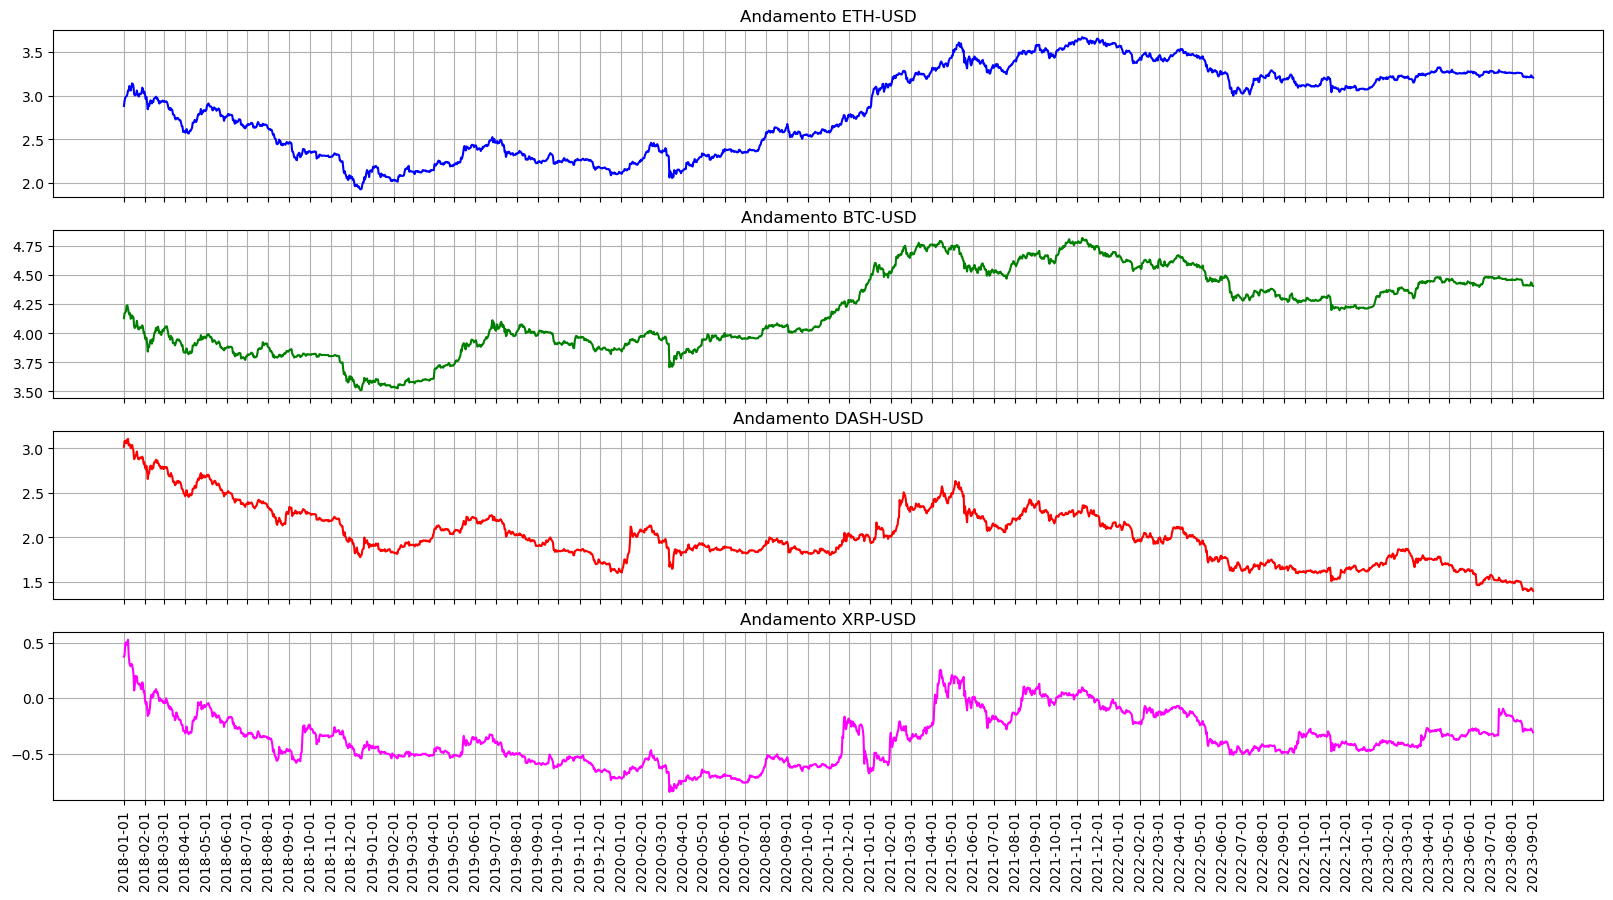

<Figure size 640x480 with 0 Axes>

In [13]:
colors = ["blue", "green", "red", "fuchsia"]
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(cryptoDataFrameDict[crypto]["LogClosePrice"], color = colors[i % len(colors)])
    axs[i].set_title("Andamento " + crypto)
    axs[i].grid(True)
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

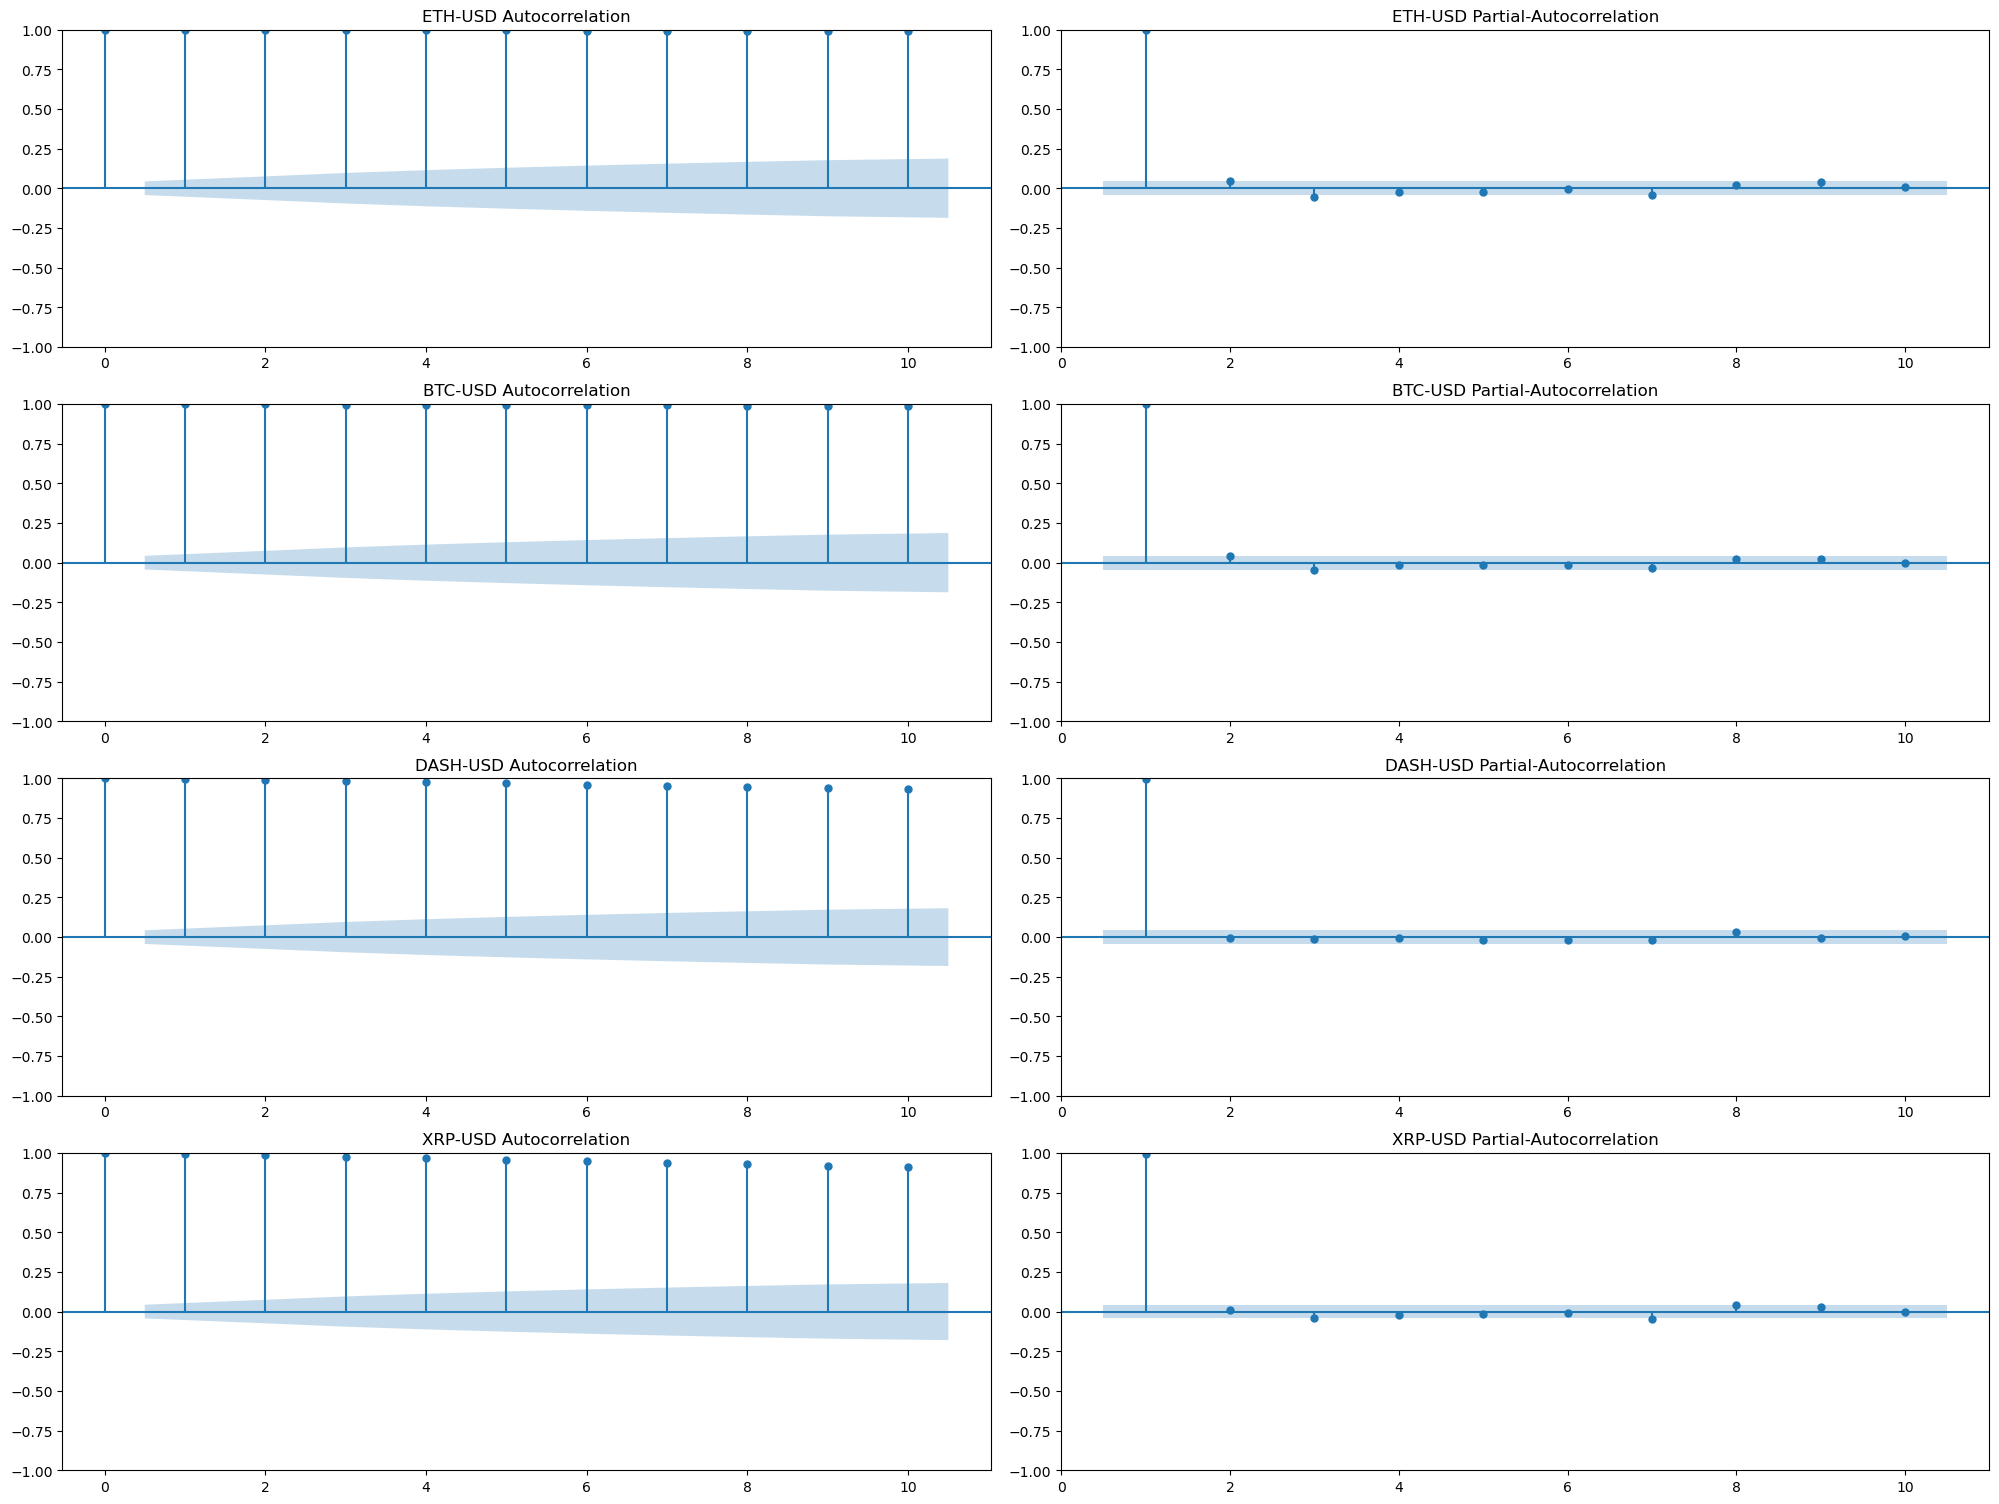

<Figure size 640x480 with 0 Axes>

In [14]:
N_LAGS = 10

fig, ax = plt.subplots(figsize=(20, 15), nrows = len(cryptoList), ncols = 2)
fig.tight_layout(h_pad = 2, w_pad =2)
i = 0 
for crypto in cryptoList :
    plot_acf(x = cryptoDataFrameDict[crypto]["LogClosePrice"], ax = ax[i][0], lags = N_LAGS, title = crypto + " Autocorrelation")
    i += 1

i = 0
for crypto in cryptoList :
    plot_pacf(x = cryptoDataFrameDict[crypto]["LogClosePrice"], ax = ax[i][1], lags = N_LAGS, title = crypto + " Partial-Autocorrelation", zero=False)
    i += 1
plt.show()
plt.clf()

### 2_2. Ricerca di una componenti di Random Walk
Le componenti di Random Walk vengono ricercate usando due Test di Ipotesi:
* ADF
* KPSS

Nel test di KPSS abbiamo:
* $H_0$ : La serie è stazionaria attorno a una tendenza deterministica (NON ha componente di Random Walk)
* $H_1$ : La serie non è stazionaria (HA componente di Random Walk)

Nel test di ADF abbiamo:
* $H_0$ : La serie ha una radice unitaria (HA componente di Random Walk)
* $H_1$ : La serie non ha una radice unitaria (NON ha componente di Random Walk)

Nel nostro caso vogliamo:
* KPSS, **Rigettare**
* ADF, **Accettare**

In [15]:
#%%capture --no-display

SIGNIFICANCE_LEVEL = 0.05

kpssTable : Table = buildTable("KPSS", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    kpssStat, pValue, _, _ = kpss(cryptoDataFrameDict[crypto]["LogClosePrice"]) ;
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    kpssTable.add_row(crypto, str(kpssStat), str(pValue), outcomeString)
console = Console()
console.print(kpssTable)

adfullerTable = buildTable("ADF", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    result = adfuller(cryptoDataFrameDict[crypto]["LogClosePrice"]) ;
    adfullerStat : float = result[0]
    pValue = result[1]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    adfullerTable.add_row(crypto, str(adfullerStat), str(pValue), outcomeString)
console = Console()
console.print(adfullerTable)

## TODO print(result)
## Conclusione: Trend stocastico presente ma abbastanza debole (per l'ultimo)

                        KPSS                        
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  4.630432272815153 │   0.01 │ Reject  │
│ BTC-USD  │  4.820559865672976 │   0.01 │ Reject  │
│ DASH-USD │ 2.7531299544913352 │   0.01 │ Reject  │
│ XRP-USD  │  0.918683154822733 │   0.01 │ Reject  │
└──────────┴────────────────────┴────────┴─────────┘

                                ADF                                
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃               pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -0.9501313424178289 │   0.7710157360162664 │ Accept  │
│ BTC-USD  │  -0.978510604401754 │   0.7610211585021541 │ Accept  │
│ DASH-USD │ -2.8180938650045064 │   0.0557353087206187 │ Accept  │
│ XRP-USD  │  -3.500868599705032 │ 0.007964814582617451 │ Reject  │
└──────────┴─────────────────────┴──────────────────────┴─────────┘

### 2_3. Differencing della serie storica e analisi del rumore
Procediamo lo studio con l'analisi del rumore.

Passiamo al differencing della serie storica, ottenendo $Y_{t+1} - Y_{t} = W_{t}$ e procedendo con un'analisi del termine $W_{t}$.

Il differencing viene fatto sul risultato del passaggio al logaritmo dei valori originari. Siano:
* *Y*, valori logaritmici
* *P*, valori originari
* *R*, rendimento

Fare il differencing dei valori logaritmici ci permette di fare quanto segue:

$Y_{t+1} - Y_{t} = \log(P_{t+1}) - \log(P_t) = \log(\frac{P_{t+1}}{P_{t}}) = \log(R) = W_t$

Ovvero analizzare se il rendimento ha o meno natura di rumore bianco

In [16]:
differencingDict : dict[str, pd.Series] = {}
for crypto in cryptoDataFrameDict :
    logPriceSeries : pd.Series = cryptoDataFrameDict[crypto]["LogClosePrice"]
    differencing : pd.Series = logPriceSeries.diff()
    differencing.dropna(inplace = True)
    differencing.reset_index(inplace = True, drop = True)
    differencingDict[crypto] = differencing

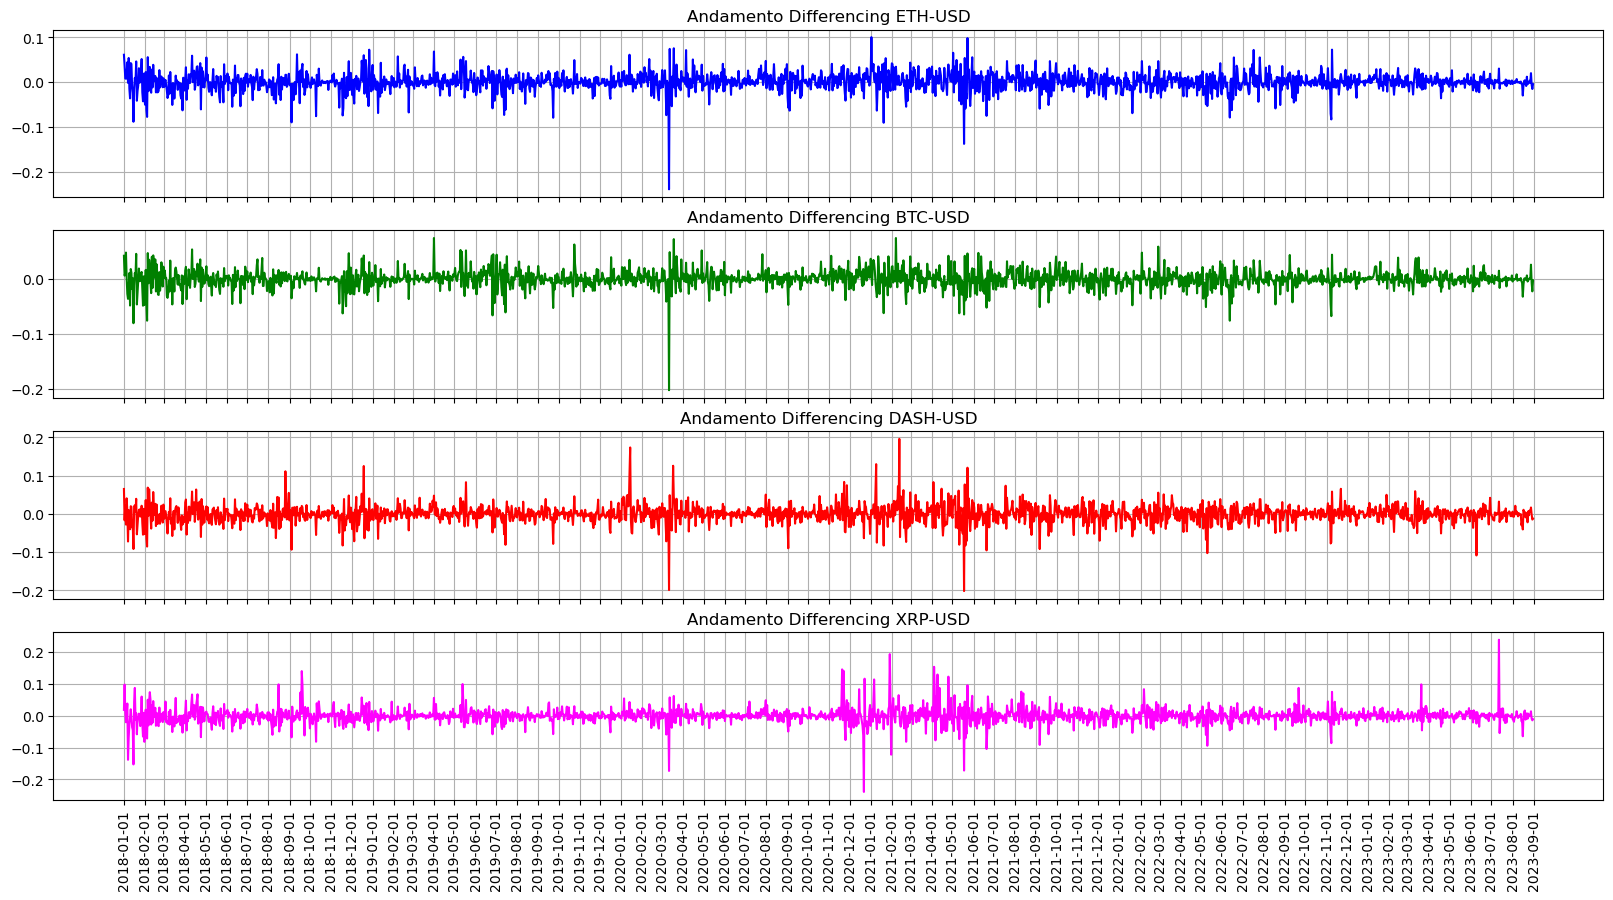

<Figure size 640x480 with 0 Axes>

In [17]:
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(differencingDict[crypto], color = colors[i % len(colors)])
    axs[i].set_title("Andamento Differencing " + crypto)
    axs[i].grid(True)
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

#### 2_3_1. Analisi Stazionarietà
Per l'analisi di stazionarietà eseguiamo due test:
* KDSS
* Adfuller

Nel test di KPSS abbiamo:
* *H0* : La serie è stazionaria attorno a una tendenza deterministica
* *H1* : La serie non è stazionaria

Nel test di Adfuller abbiamo:
* *H0* : La serie ha una radice unitaria
* *H1* : La serie non ha una radice unitaria

Nel nostro caso vogliamo:
* KPSS, **Accettare**
* Adfuller, **Rigettare**

In [18]:
%%capture --no-display

SIGNIFICANCE_LEVEL = 0.05

kpssTable : Table = buildTable("KPSS", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    kpssStat, pValue, _, _ = kpss(differencingDict[crypto])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    kpssTable.add_row(crypto, str(kpssStat), str(pValue), outcomeString)
console = Console()
console.print(kpssTable)

adfullerTable = buildTable("Adfuller", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    result = adfuller(differencingDict[crypto])
    adfullerStat : float = result[0]
    pValue = result[1]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    adfullerTable.add_row(crypto, str(adfullerStat), str(pValue), outcomeString)
console = Console()
console.print(adfullerTable)

                        KPSS                         
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.23201574524870314 │    0.1 │ Accept  │
│ BTC-USD  │ 0.15674142996559834 │    0.1 │ Accept  │
│ DASH-USD │ 0.13769918829263092 │    0.1 │ Accept  │
│ XRP-USD  │ 0.19808342863898767 │    0.1 │ Accept  │
└──────────┴─────────────────────┴────────┴─────────┘

                              Adfuller                               
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -13.748813873133498 │ 1.0600349812346284e-25 │ Reject  │
│ BTC-USD  │ -31.470467916876196 │                    0.0 │ Reject  │
│ DASH-USD │ -21.645263875919735 │                    0.0 │ Reject  │
│ XRP-USD  │  -46.79501030099321 │                    0.0 │ Reject  │
└──────────┴─────────────────────┴────────────────────────┴─────────┘

Dal test di KPSS e dal test ADF, possiamo concludere che il differencing $W_t$ è stazionario

#### 2_3_2. Analisi Eteroschedasticità
Per l'analisi di eteroschedasticità eseguiamo i seguenti test:
* Breusch-Pagan
* White

Nel test di Breusch-Pagan abbiamo:
* $H_0$: I residui sono distribuiti con varianza omogenea (La serie è Omoschedastica)
* $H_1$: I residui *NON* sono distribuiti con varianza omogenea (La serie *NON* è omoschedastica)

Nel test di White abbiamo:
* $H_0$: La varianza dei residui è costante (La serie è Omoschedastica)
* $H_1$: La varianza dei residui *NON* è costante (La serie *NON* è Omoschedastica)

In questo caso vogliamo:
* Breusch-Pagan, **Accettare**
* White, **Accettare**

In [19]:
# Crea il modello
SIGNIFICANCE_LEVEL = 0.05
bpTable = buildTable("Breusch-Pagan", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
whiteTable = buildTable("White", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])

console = Console()

for crypto in cryptoList :
    x = sm.add_constant(differencingDict[crypto].index.tolist())
    model = sm.OLS(differencingDict[crypto].values, x)
    fittedModel = model.fit()
    console.print(crypto + "\n" + str(fittedModel.summary()))
    residKurtosis = kurtosis(fittedModel.resid)

    # In the general description of LM test, Greene mentions that this test exaggerates the significance of results in small or moderately large samples. 
    # In this case the F-statistic is preferable.

    # BREUSCH-PAGAN TEST
    lmValue, lm_pvalue, fValue, f_pvalue = het_breuschpagan(fittedModel.resid, fittedModel.model.exog, residKurtosis > 0.05)

    statValue, pValue = fValue, f_pvalue
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    bpTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
    # WHITE TEST
    lmValue, lm_pvalue, fValue, f_pvalue = het_white(fittedModel.resid, fittedModel.model.exog)
    statValue, pValue = fValue, f_pvalue
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    whiteTable.add_row(crypto, str(statValue), str(pValue), outcomeString)


console.print(bpTable)
console.print(whiteTable)

ETH-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5481
Date:                gio, 16 nov 2023   Prob (F-statistic):              0.459
Time:                        11:54:08   Log-Likelihood:                 5049.8
No. Observations:                2069   AIC:                        -1.010e+04
Df Residuals:                    2067   BIC:                        -1.008e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.472      0.637      -0.002       0.001
x1          5.746e-07   7.76e-07      0.740      0.459   -9.47e-07     2.1e-06
==============================================================================
Omnibus:                      632.947   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10358.413
Skew:                          -0.995   Prob(JB):                         0.00
Kurtosis:                      13.779   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

BTC-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1443
Date:                gio, 16 nov 2023   Prob (F-statistic):              0.704
Time:                        11:54:08   Log-Likelihood:                 5578.7
No. Observations:                2069   AIC:                        -1.115e+04
Df Residuals:                    2067   BIC:                        -1.114e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.143      0.887      -0.002       0.001
x1          2.283e-07   6.01e-07      0.380      0.704    -9.5e-07    1.41e-06
==============================================================================
Omnibus:                      697.962   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16730.990
Skew:                          -1.029   Prob(JB):                         0.00
Kurtosis:                      16.778   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

DASH-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3637
Date:                gio, 16 nov 2023   Prob (F-statistic):              0.547
Time:                        11:54:08   Log-Likelihood:                 4747.7
No. Observations:                2069   AIC:                            -9491.
Df Residuals:                    2067   BIC:                            -9480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.252      0.211      -0.003       0.001
x1          5.417e-07   8.98e-07      0.603      0.547   -1.22e-06     2.3e-06
==============================================================================
Omnibus:                      376.450   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8823.543
Skew:                          -0.083   Prob(JB):                         0.00
Kurtosis:                      13.116   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

XRP-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.386
Date:                gio, 16 nov 2023   Prob (F-statistic):              0.239
Time:                        11:54:08   Log-Likelihood:                 4673.8
No. Observations:                2069   AIC:                            -9344.
Df Residuals:                    2067   BIC:                            -9332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.315      0.189      -0.004       0.001
x1          1.096e-06   9.31e-07      1.177      0.239    -7.3e-07    2.92e-06
==============================================================================
Omnibus:                      510.216   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22254.586
Skew:                           0.337   Prob(JB):                         0.00
Kurtosis:                      19.053   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

                           Breusch-Pagan                           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  8.567367566736669 │ 0.0034597918568196914 │ Reject  │
│ BTC-USD  │  7.763759935805086 │  0.005379165131515243 │ Reject  │
│ DASH-USD │  2.276765009171112 │    0.1314783730532143 │ Accept  │
│ XRP-USD  │ 1.2467607341644058 │    0.2643018406639988 │ Accept  │
└──────────┴────────────────────┴───────────────────────┴─────────┘

                              White                               
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃               pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │   5.26508181913567 │ 0.005238555530471663 │ Reject  │
│ BTC-USD  │  4.141400487811925 │ 0.016032762971599328 │ Reject  │
│ DASH-USD │  3.666072606577798 │ 0.025743255972081297 │ Reject  │
│ XRP-USD  │ 0.7598677076192619 │   0.4678589731665155 │ Accept  │
└──────────┴────────────────────┴──────────────────────┴─────────┘

#### 2_3_3. Analisi Autocorrelazione

Per l'Autocorrelazione consideriamo i seguenti test:
* Ljung-Box

Per il test Ljung-Box:
* $H_0$: Non c'è autocorrelazione nei dati. In altre parole, i residui sono indipendenti l'uno dall'altro e non mostrano alcuna struttura di autocorrelazione significativa.
* $H_1$: I residui non sono indipendenti e mostrano una struttura di autocorrelazione significativa.

Vogliamo quindi :
* Ljung-Box, **Accettare**

In [20]:
N_LAGS = 10
SIGNIFICANCE_LEVEL = 0.05
ljungTable = buildTable("Ljung-Box", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    testResult = acorr_ljungbox(differencingDict[crypto], lags = N_LAGS)
    statValue, pValue = testResult["lb_stat"][N_LAGS], testResult["lb_pvalue"][N_LAGS]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    ljungTable.add_row(crypto, str(statValue), str(pValue), outcomeString)

console = Console()
console.print(ljungTable)

                             Ljung-Box                             
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 31.609722534078987 │ 0.0004650065716092994 │ Reject  │
│ BTC-USD  │ 16.925034452734113 │   0.07603932218108504 │ Accept  │
│ DASH-USD │ 15.716773963771859 │   0.10803220218423684 │ Accept  │
│ XRP-USD  │  7.977674132723926 │     0.631017790629593 │ Accept  │
└──────────┴────────────────────┴───────────────────────┴─────────┘

Tracciamo gli autocorrelogrammi e gli autocorrelogrammi parziali dei dati.

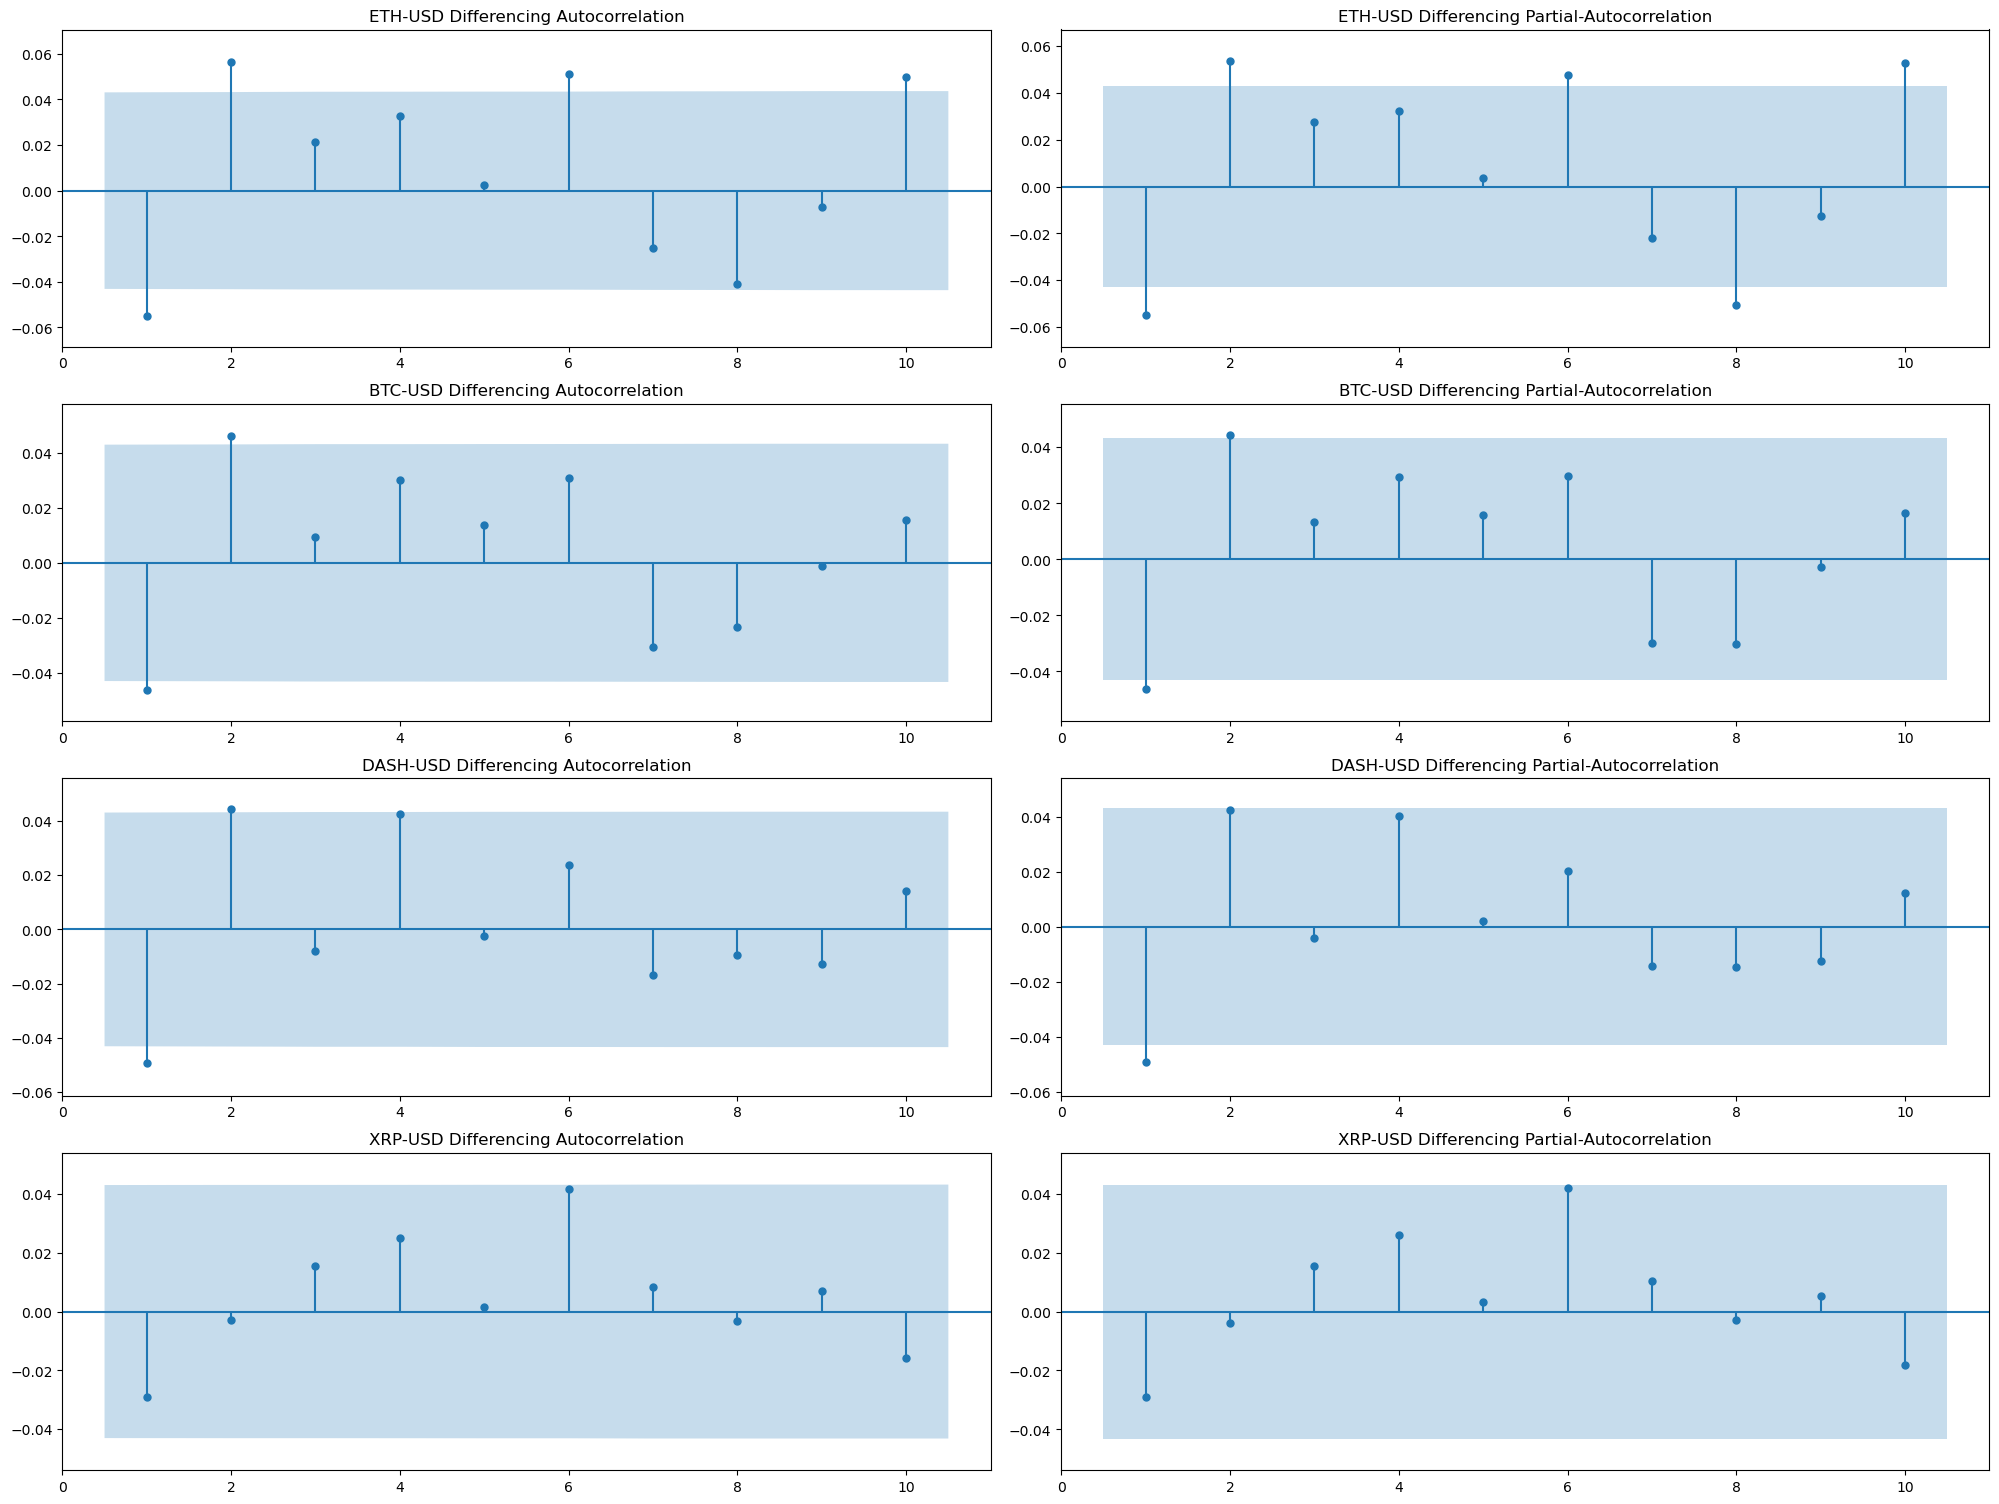

<Figure size 640x480 with 0 Axes>

In [21]:
N_LAGS = 10

fig, ax = plt.subplots(figsize=(20, 15), nrows = len(cryptoList), ncols = 2)
fig.tight_layout(h_pad = 2, w_pad = 2)
i = 0 
for crypto in cryptoList :
    axs[i].set_xticks(np.arange(0, N_LAGS, 1))
    axs[i].set_xticklabels(np.arange(0, N_LAGS, 1))
    plot_acf(x = differencingDict[crypto], ax = ax[i][0], lags = N_LAGS, title = crypto + " Differencing Autocorrelation", zero = False, auto_ylims = True)
    i += 1

i = 0 
for crypto in cryptoList :
    plot_pacf(x = differencingDict[crypto], ax = ax[i][1], lags = N_LAGS, title = crypto + " Differencing Partial-Autocorrelation", zero = False, auto_ylims = True)
    i += 1

plt.show()
plt.clf()

Il test quindi Accetta per entrambi i casi e i dati non dovrebbero essere autocorrelati.
Tuttavia, osservando i grafici relativi al differencing, possiamo notare come vi siano dei cluster di varianza costante, in cui a basse varianze seguono zone di bassa varianza (analogamente per quelle ad alta varianza).

Riassumendo abbiamo:
* Accettazione del test di Ljung-Box
* Presenza di clusterizzazione delle varianze
Questo fenomeno potrebbe essere dovuto al fatto che i dati sono molti, e quindi il grande numero di dati potrebbe offuscare l'autocorrelazione portando i dati a tendere al gaussiano.

Ci fa supporre la presenza di punti di rottura nella struttura. 

Passiamo quindi, dopo dei veloci test sulla gaussianità, all'analisi delle rotture strutturali.

#### 2_3_4. Analisi Normalità
Per l'analisi di normalità eseguiamo i seguenti test:
* Shapiro-Wilk
* Kolmogorov-Smirnov

Nel test di Shapiro-Wilk abbiamo:
* $H_0$: I dati seguono una distribuzione normale
* $H_1$: I dati NON seguono una distribuzione normale

Nel test di Kolmogorov-Smirnov abbiamo:
* $H_0$: I dati seguono la distribuzione specificata
* $H_1$: I dati NON seguono la distribuzione specificata

Nel nostro caso vogliamo:
* Shapiro-Wilk, **Accettare**
* Kolmogorov-Smirnov, **Accettare**

In [22]:
#%%capture --no-display
SIGNIFICANCE_LEVEL = 0.05

# Esegue il test di normalità di Shapiro-Wilk
shapiroTable = buildTable("Shapiro-Wilk", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList:   
    statValue, pValue = shapiro(differencingDict[crypto])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    shapiroTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
console = Console()
console.print(shapiroTable)

ksTable = buildTable("Kolmogorov-Smirnov", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList:   
    statValue, pValue = kstest(differencingDict[crypto], norm.cdf)
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    ksTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
console = Console()
console.print(ksTable)


                            Shapiro-Wilk                            
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.9225029349327087 │  2.243272511905845e-31 │ Reject  │
│ BTC-USD  │ 0.9065624475479126 │  7.687562699532387e-34 │ Reject  │
│ DASH-USD │ 0.9040272235870361 │ 3.3494620980164206e-34 │ Reject  │
│ XRP-USD  │ 0.8357081413269043 │   7.15923385423549e-42 │ Reject  │
└──────────┴────────────────────┴────────────────────────┴─────────┘

                 Kolmogorov-Smirnov                  
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  0.4705378122861261 │    0.0 │ Reject  │
│ BTC-USD  │ 0.47608764853183083 │    0.0 │ Reject  │
│ DASH-USD │ 0.46608875744466827 │    0.0 │ Reject  │
│ XRP-USD  │  0.4642030732172747 │    0.0 │ Reject  │
└──────────┴─────────────────────┴────────┴─────────┘

Notiamo quindi che i due test ci fanno rigettare in entrambi i casi l'ipotesi nulla di normalità dei dati.
Per completezza tracciamo un grafico dei dati.

### 2_4. Analisi dei Punti di Rottura nella Struttura
Cerchiamo i punti di rottura usando la funzione *breakpoints* del package *strucchange* di R.

In [61]:
# Loading the function we have defined in R.
r['source']('./R/R_Scripts.R')


breakPointSearch_R = robjects.globalenv['breakPointSearch']
fstatBreakpointsSearch_R = robjects.globalenv['fstatBreakpointsSearch']
supmzBreakpointsSearch_R = robjects.globalenv['supmzBreakpointsSearch']

cryptoBreakPointsDict = {}
for crypto in cryptoList :
    ## Converting to R dataFrame
    closePrice_R = pandas2ri.py2rpy(cryptoDataFrameDict[crypto]["LogClosePrice"])

    # Invoking R function
    breakPointsList_R = breakPointSearch_R(closePrice_R)

    #Converting it back to a pandas dataframe.
    breakPointsList = pandas2ri.ri2py_vector(breakPointsList_R)

    breakPointsList = [int(elem - 1) for elem in breakPointsList]
    cryptoBreakPointsDict[crypto] = breakPointsList

    

    fstatPointsList_R = fstatBreakpointsSearch_R(closePrice_R)
    fstatBreakPointsList = pandas2ri.ri2py_vector(fstatPointsList_R)
    fstatBreakPointsList = [int(elem - 1) for elem in fstatBreakPointsList]
    print(crypto)
    print(cryptoDataFrameDict[crypto]["Date"].loc[fstatBreakPointsList])

    dataFrame_R = pandas2ri.py2(cryptoDataFrameDict[crypto]["LogClosePrice"])
    supmzPointsList_R = supmzBreakpointsSearch_R(dataFrame_R)
    supmzBreakPointsList = pandas2ri.ri2py_vector(supmzPointsList_R)

R[write to console]: Errore in model.frame.default(formula = formula, data = data, subset = NULL,  : 
  'data' dev'essere un data.frame, un ambiente o una lista



ETH-USD
1093    2020-12-29
Name: Date, dtype: object


RRuntimeError: Errore in model.frame.default(formula = formula, data = data, subset = NULL,  : 
  'data' dev'essere un data.frame, un ambiente o una lista


In [24]:
breakPointsTable = buildTable("Structural Breakpoints", ["Crypto", "Breakpoint Dates"], ["left", "right"])
for crypto in cryptoList :
    datesString = "| "
    for breakpoint in cryptoBreakPointsDict[crypto] :
        date = cryptoDataFrameDict[crypto]["Date"].loc[breakpoint]
        datesString += date + " | "
    breakPointsTable.add_row(crypto, datesString)

console = Console()
console.print(breakPointsTable)

                       Structural Breakpoints                        
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Crypto   ┃                                       Breakpoint Dates ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ETH-USD  │  | 2018-11-06 | 2020-02-06 | 2021-01-02 | 2022-05-10 | │
│ BTC-USD  │               | 2019-05-12 | 2020-12-15 | 2022-05-08 | │
│ DASH-USD │  | 2018-11-06 | 2019-09-22 | 2021-01-09 | 2022-05-04 | │
│ XRP-USD  │  | 2018-11-18 | 2019-09-24 | 2021-02-08 | 2022-04-28 | │
└──────────┴────────────────────────────────────────────────────────┘

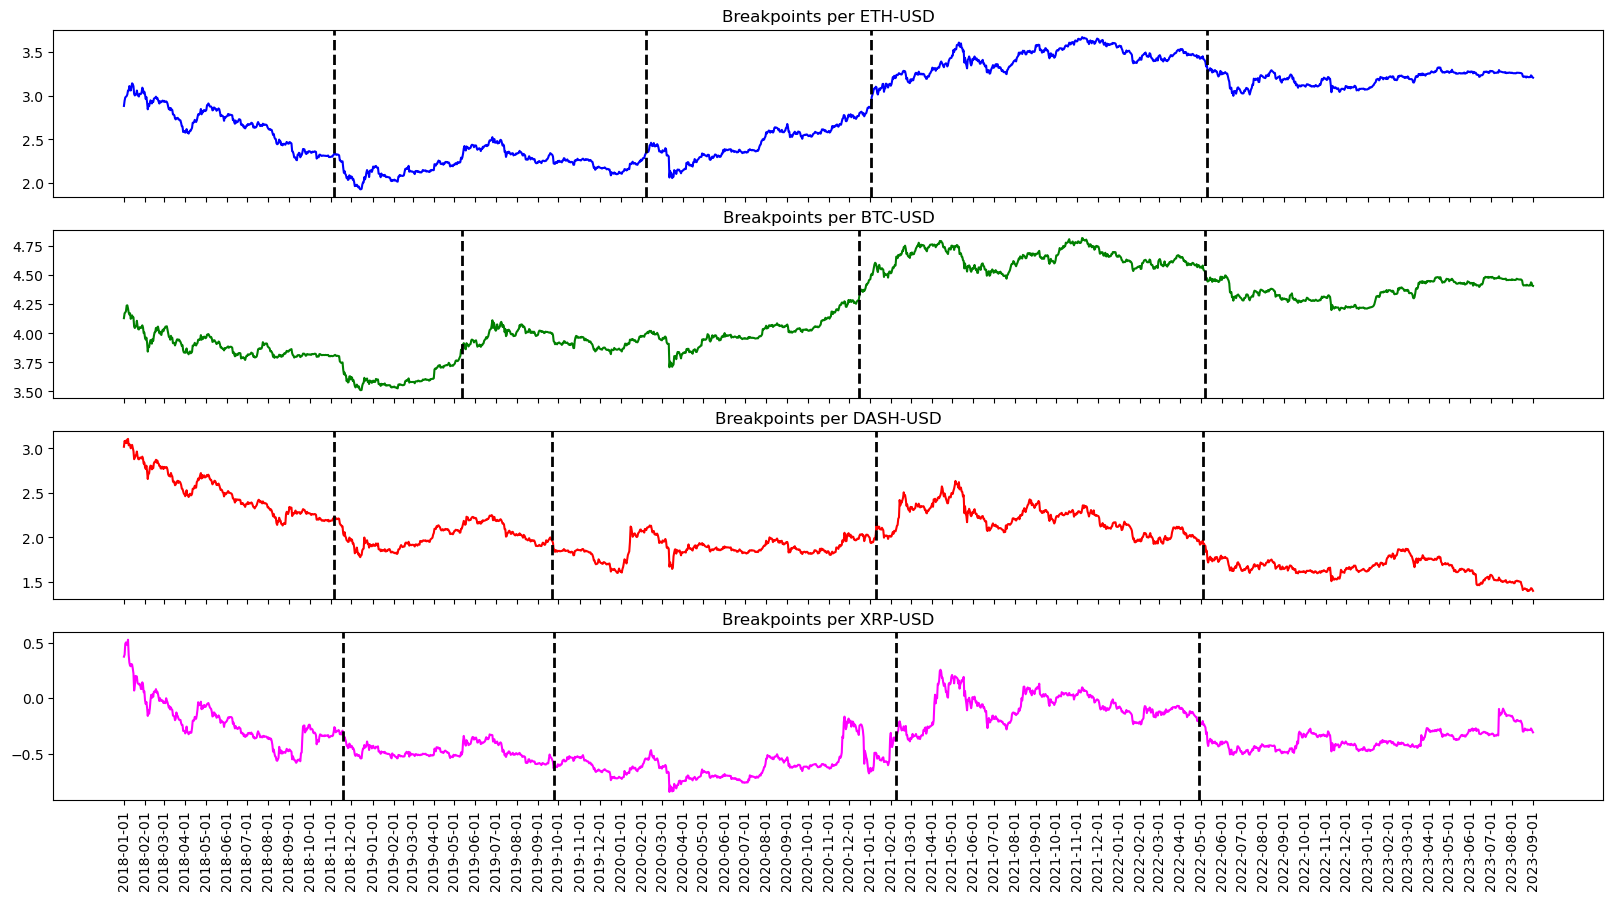

<Figure size 640x480 with 0 Axes>

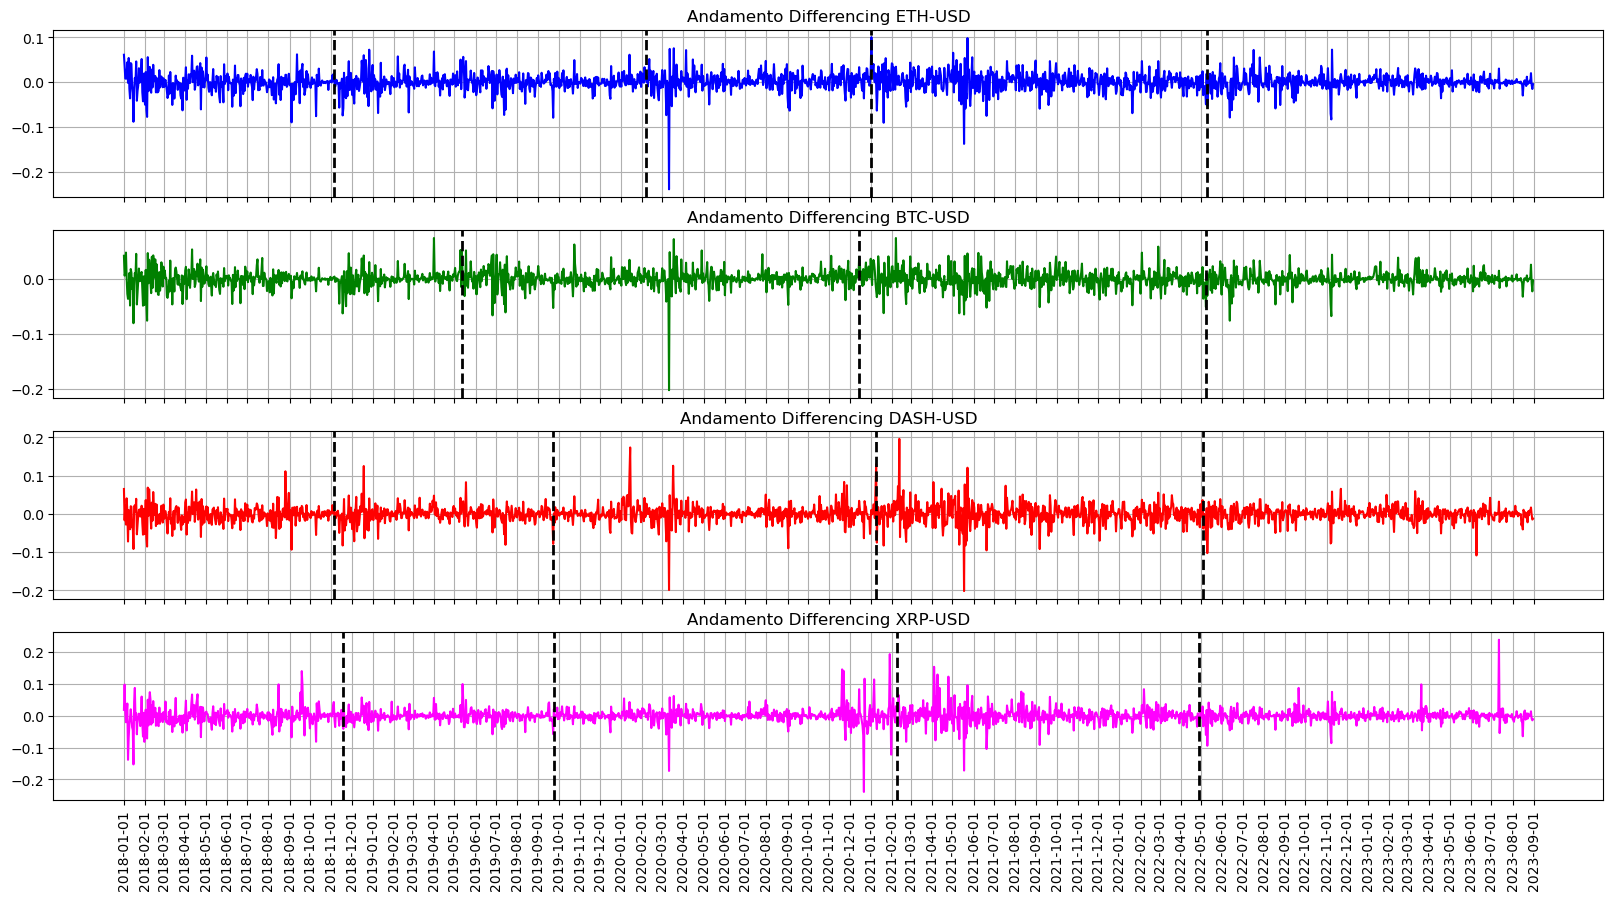

<Figure size 640x480 with 0 Axes>

In [25]:
colors = ["blue", "green", "red", "fuchsia"]
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(cryptoDataFrameDict[crypto]["LogClosePrice"], color = colors[i % len(colors)])
    axs[i].set_title("Breakpoints per " + crypto)
    # axs[i].grid(True)

    for breakpoint in cryptoBreakPointsDict[crypto] :
        axs[i].axvline(x = breakpoint, color = "black", linestyle = "--", linewidth = "2")

    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()


figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(differencingDict[crypto], color = colors[i % len(colors)])
    axs[i].set_title("Andamento Differencing " + crypto)
    axs[i].grid(True)

    for breakpoint in cryptoBreakPointsDict[crypto] :
        axs[i].axvline(x = breakpoint, color = "black", linestyle = "--", linewidth = "2")
        
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

I test rilevano quindi la presenza di punti di rottura.
Notiamo che un punto di rottura per tutti gli strumenti si manifesta nel *Maggio 2022*.
A questo punto possiamo restringerci a considerare i dati che vanno dall'ultimo punto di rottura in poi per ogni set di dati.

## 3. Analisi dei dati ristretti

In [26]:
restrCryptoDataFrameDict : dict[str, pd.DataFrame] = {}
restrDiffDataFrameDict : dict[str, pd.DataFrame] = {}

for crypto in cryptoList :
    breakPoint = cryptoBreakPointsDict[crypto][len(cryptoBreakPointsDict[crypto]) - 1]

    restrictedDataFrame : pd.DataFrame = cryptoDataFrameDict[crypto].iloc[cryptoDataFrameDict[crypto].index >= breakPoint]
    restrictedDataFrame.reset_index(drop = True, inplace = True)
    restrCryptoDataFrameDict[crypto] = restrictedDataFrame

    restrictedDiffDataFrame : pd.DataFrame = differencingDict[crypto].iloc[differencingDict[crypto].index >= breakPoint]
    restrictedDiffDataFrame.reset_index(drop = True, inplace = True)
    restrDiffDataFrameDict[crypto] = restrictedDiffDataFrame


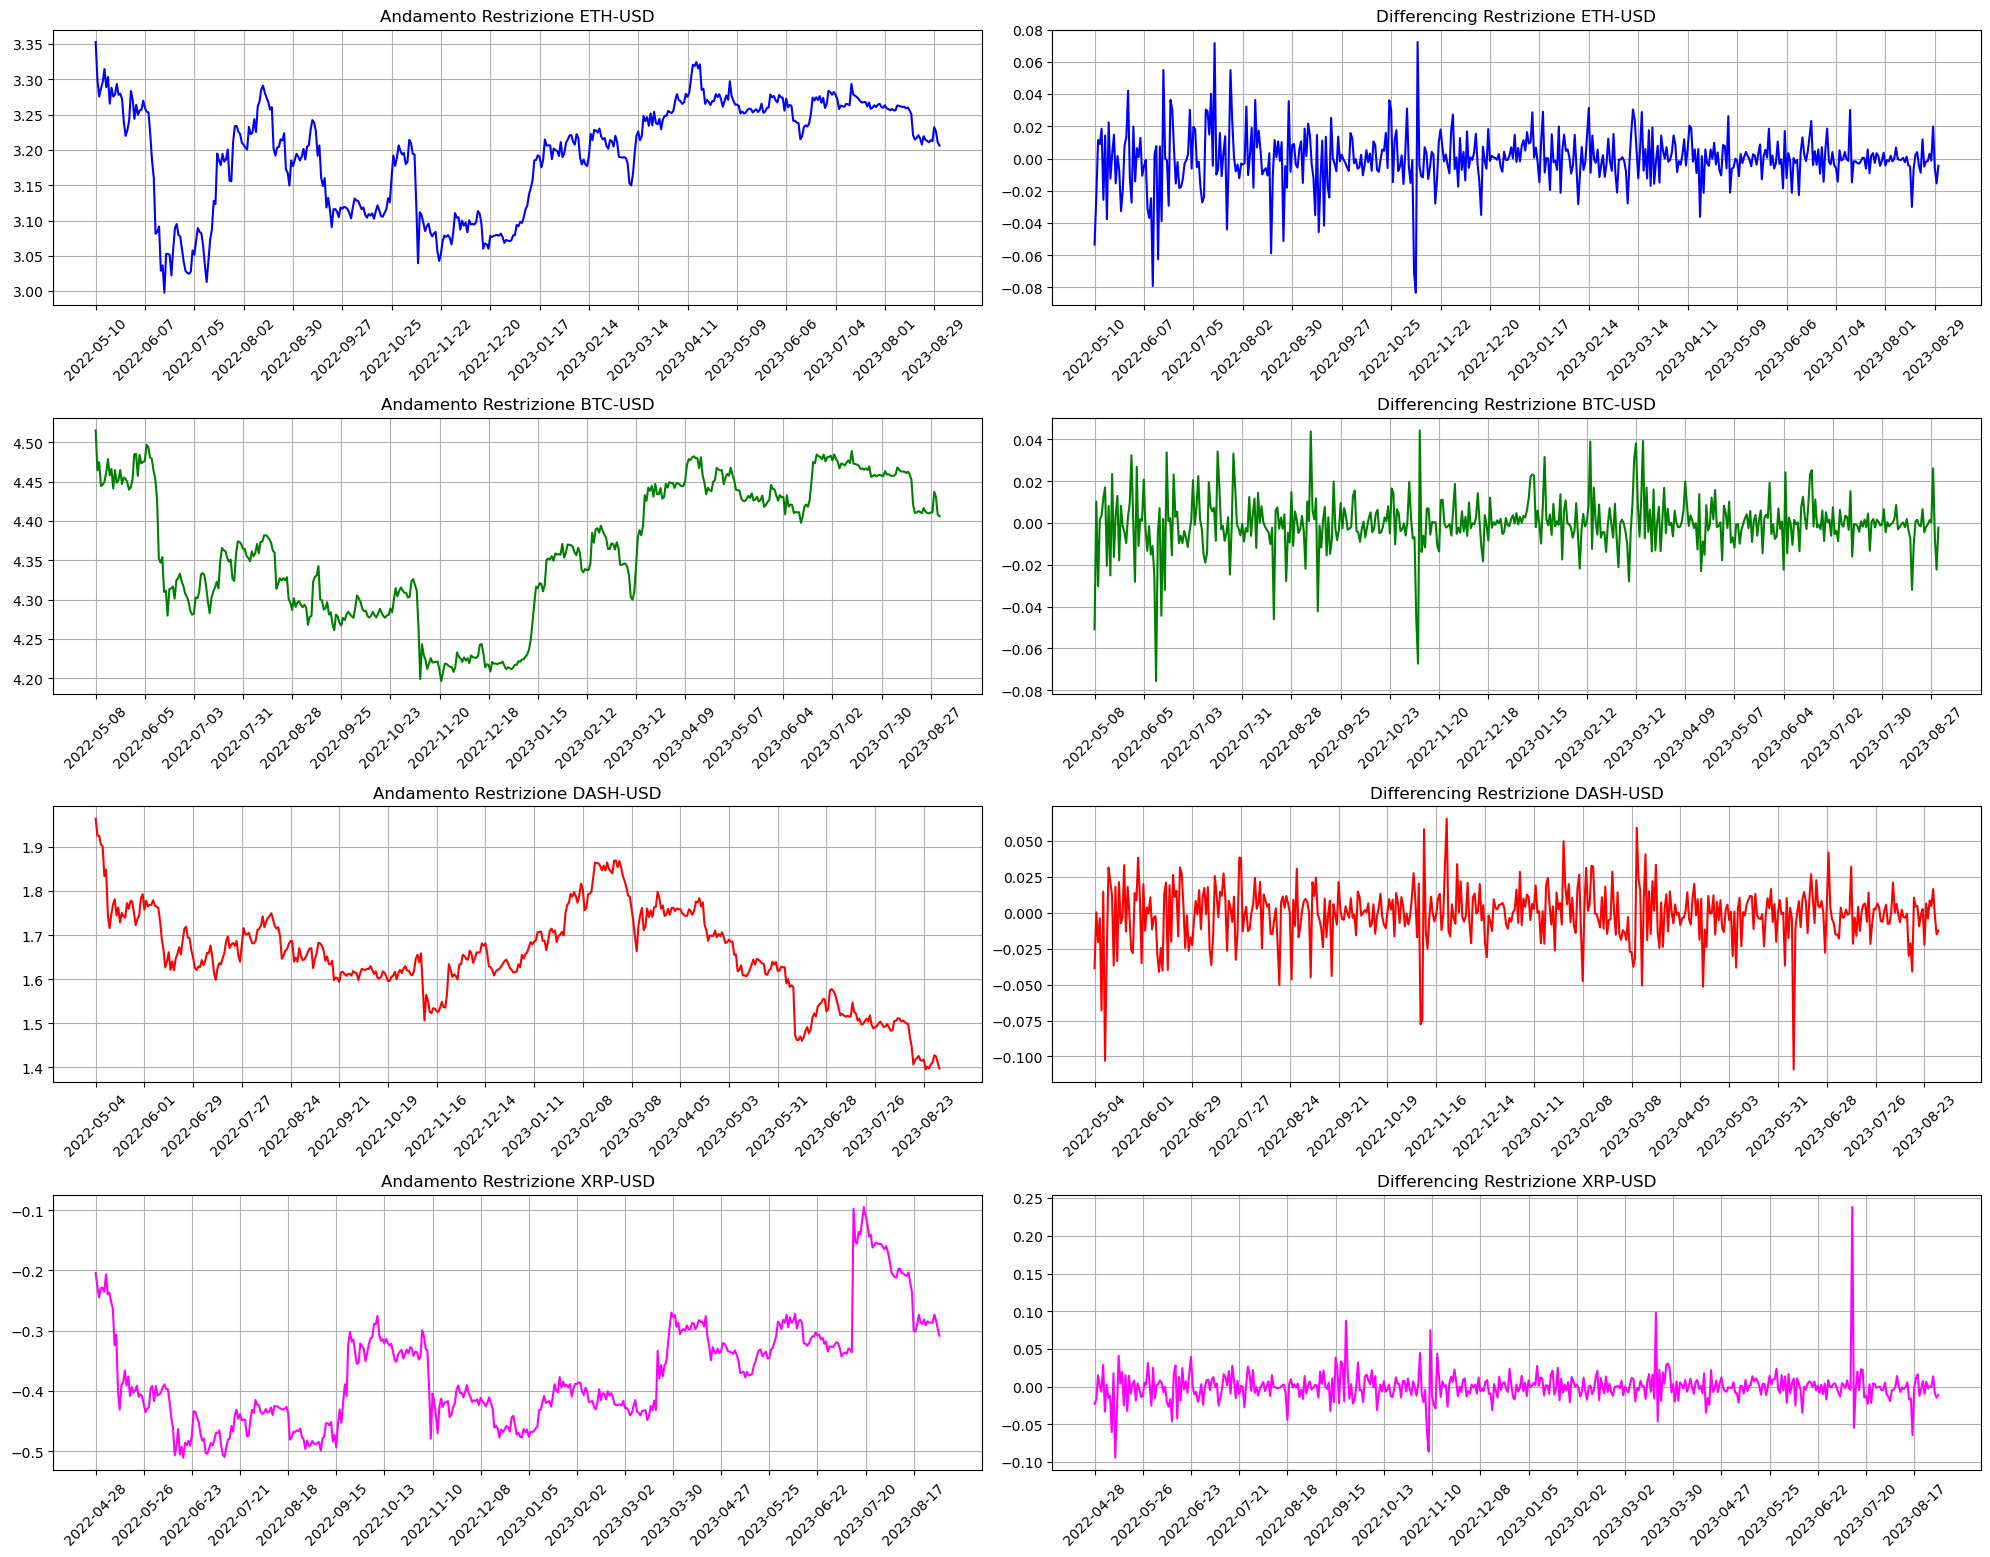

<Figure size 640x480 with 0 Axes>

In [27]:
colors = ["blue", "green", "red", "fuchsia"]
figure, axs = plt.subplots(nrows = len(cryptoList), ncols = 2, figsize = (20,15))
figure.tight_layout(h_pad = 6, w_pad = 2)

STEP = 28
ROTATION = 45

i = 0 
for crypto in cryptoList :
    axs[i][0].plot(restrCryptoDataFrameDict[crypto]["LogClosePrice"], color = colors[i % len(colors)])
    axs[i][0].set_title("Andamento Restrizione " + crypto)
    axs[i][0].grid(True)

    xtickPoints = np.arange(start = 0, stop = restrCryptoDataFrameDict[crypto].shape[0], step = STEP)
    xtickLabels = restrCryptoDataFrameDict[crypto]["Date"].iloc[xtickPoints]
    axs[i][0].set_xticks(xtickPoints)
    axs[i][0].set_xticklabels(xtickLabels, rotation = ROTATION)

    i += 1

i = 0 
for crypto in cryptoList :
    axs[i][1].plot(restrDiffDataFrameDict[crypto], color = colors[i % len(colors)])
    axs[i][1].set_title("Differencing Restrizione " + crypto)
    axs[i][1].grid(True)

    xtickPoints = np.arange(start = 0, stop = restrCryptoDataFrameDict[crypto].shape[0], step = STEP)
    xtickLabels = restrCryptoDataFrameDict[crypto]["Date"].iloc[xtickPoints]
    axs[i][1].set_xticks(xtickPoints)
    axs[i][1].set_xticklabels(xtickLabels, rotation = ROTATION)

    i += 1

plt.show()
plt.clf()

#### 3_1. Analisi del differencing ridotto
Come nel primo caso analizziamo il differencing e vediamo se questo ha natura di white noise.

##### 3_1_1. Analisi Stazionarietà
Per l'analisi di stazionarietà eseguiamo due test:
* KDSS
* Adfuller

Nel test di KPSS abbiamo:
* *H0* : La serie è stazionaria attorno a una tendenza deterministica
* *H1* : La serie non è stazionaria

Nel test di Adfuller abbiamo:
* *H0* : La serie ha una radice unitaria
* *H1* : La serie non ha una radice unitaria

Nel nostro caso vogliamo:
* KPSS, **Accettare**
* Adfuller, **Rigettare**

In [28]:
%%capture --no-display

SIGNIFICANCE_LEVEL = 0.05

kpssTable : Table = buildTable("KPSS", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    kpssStat, pValue, _, _ = kpss(restrDiffDataFrameDict[crypto])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    kpssTable.add_row(crypto, str(kpssStat), str(pValue), outcomeString)
console = Console()
console.print(kpssTable)

adfullerTable = buildTable("Adfuller", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    result = adfuller(restrDiffDataFrameDict[crypto])
    adfullerStat : float = result[0]
    pValue = result[1]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    adfullerTable.add_row(crypto, str(adfullerStat), str(pValue), outcomeString)
console = Console()
console.print(adfullerTable)

                        KPSS                         
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.13457357311289336 │    0.1 │ Accept  │
│ BTC-USD  │ 0.23515563368807982 │    0.1 │ Accept  │
│ DASH-USD │ 0.13101866808825066 │    0.1 │ Accept  │
│ XRP-USD  │ 0.12256319567979125 │    0.1 │ Accept  │
└──────────┴─────────────────────┴────────┴─────────┘

                      Adfuller                       
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  -22.68028167813743 │    0.0 │ Reject  │
│ BTC-USD  │  -22.33083525249086 │    0.0 │ Reject  │
│ DASH-USD │ -21.818118706214925 │    0.0 │ Reject  │
│ XRP-USD  │  -25.84175925777767 │    0.0 │ Reject  │
└──────────┴─────────────────────┴────────┴─────────┘

##### 3_1_2. Analisi Eteroschedasticità
Per l'analisi di eteroschedasticità eseguiamo i seguenti test:
* Breusch-Pagan
* White

Nel test di Breusch-Pagan abbiamo:
* $H_0$: I residui sono distribuiti con varianza omogenea (La serie è Omoschedastica)
* $H_1$: I residui *NON* sono distribuiti con varianza omogenea (La serie *NON* è omoschedastica)

Nel test di White abbiamo:
* $H_0$: La varianza dei residui è costante (La serie è Omoschedastica)
* $H_1$: La varianza dei residui *NON* è costante (La serie *NON* è Omoschedastica)

In questo caso vogliamo:
* Breusch-Pagan, **Accettare**
* White, **Accettare**

In [29]:
# Crea il modello
SIGNIFICANCE_LEVEL = 0.05
bpTable = buildTable("Breusch-Pagan", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
whiteTable = buildTable("White", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
kurtTable = buildTable("Kurtosis", ["Crypto", "Kurtosis"], ["left", "right"])

console = Console()

for crypto in cryptoList :
    x = sm.add_constant(restrDiffDataFrameDict[crypto].index.tolist())
    model = sm.OLS(restrDiffDataFrameDict[crypto].values, x)
    fittedModel = model.fit()
    console.print(crypto + "\n" + str(fittedModel.summary()))
    residKurtosis = kurtosis(fittedModel.resid)
    kurtTable.add_row(crypto, str(residKurtosis))

    # In the general description of LM test, Greene mentions that this test exaggerates the significance of results in small or moderately large samples. 
    # In this case the F-statistic is preferable.

    # BREUSCH-PAGAN TEST
    lmValue, lm_pvalue, fValue, f_pvalue = het_breuschpagan(fittedModel.resid, fittedModel.model.exog, residKurtosis > 0.05)

    statValue, pValue = fValue, f_pvalue
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    bpTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
    # WHITE TEST
    lmValue, lm_pvalue, fValue, f_pvalue = het_white(fittedModel.resid, fittedModel.model.exog)
    statValue, pValue = fValue, f_pvalue
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    whiteTable.add_row(crypto, str(statValue), str(pValue), outcomeString)


# console.print(kurtTable)
console.print(bpTable)
console.print(whiteTable)

ETH-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6581
Date:                gio, 16 nov 2023   Prob (F-statistic):              0.418
Time:                        11:55:06   Log-Likelihood:                 1283.5
No. Observations:                 479   AIC:                            -2563.
Df Residuals:                     477   BIC:                            -2555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.904      0.366      -0.004       0.002
x1          4.459e-06    5.5e-06      0.811      0.418   -6.34e-06    1.53e-05
==============================================================================
Omnibus:                       70.518   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.727
Skew:                          -0.376   Prob(JB):                    1.01e-107
Kurtosis:                       7.911   Cond. No.                         551.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

BTC-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.431
Date:                gio, 16 nov 2023   Prob (F-statistic):              0.232
Time:                        11:55:06   Log-Likelihood:                 1418.0
No. Observations:                 481   AIC:                            -2832.
Df Residuals:                     479   BIC:                            -2824.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -1.232      0.219      -0.004       0.001
x1          4.996e-06   4.18e-06      1.196      0.232   -3.21e-06    1.32e-05
==============================================================================
Omnibus:                       95.286   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              696.792
Skew:                          -0.629   Prob(JB):                    4.94e-152
Kurtosis:                       8.761   Cond. No.                         554.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

DASH-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.05495
Date:                gio, 16 nov 2023   Prob (F-statistic):              0.815
Time:                        11:55:06   Log-Likelihood:                 1232.2
No. Observations:                 485   AIC:                            -2460.
Df Residuals:                     483   BIC:                            -2452.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.877      0.381      -0.005       0.002
x1          1.453e-06    6.2e-06      0.234      0.815   -1.07e-05    1.36e-05
==============================================================================
Omnibus:                      111.531   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              509.866
Skew:                          -0.933   Prob(JB):                    1.92e-111
Kurtosis:                       7.664   Cond. No.                         558.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

XRP-USD
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7757
Date:                gio, 16 nov 2023   Prob (F-statistic):              0.379
Time:                        11:55:06   Log-Likelihood:                 1218.3
No. Observations:                 491   AIC:                            -2433.
Df Residuals:                     489   BIC:                            -2424.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.878      0.380      -0.005       0.002
x1          5.686e-06   6.46e-06      0.881      0.379      -7e-06    1.84e-05
==============================================================================
Omnibus:                      426.837   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34890.778
Skew:                           3.231   Prob(JB):                         0.00
Kurtosis:                      43.788   Cond. No.                         565.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                            Breusch-Pagan                            
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │   32.09408640048195 │ 2.5431491437787065e-08 │ Reject  │
│ BTC-USD  │  14.541990336444472 │ 0.00015498065538407336 │ Reject  │
│ DASH-USD │   5.526786321745021 │   0.019128556618873097 │ Reject  │
│ XRP-USD  │ 0.28861588999599835 │     0.5913532343542178 │ Accept  │
└──────────┴─────────────────────┴────────────────────────┴─────────┘

                               White                                
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 17.214137789863397 │  6.053273884023815e-08 │ Reject  │
│ BTC-USD  │   8.59365204494447 │ 0.00021545493367190117 │ Reject  │
│ DASH-USD │ 3.5632000252700626 │   0.029097129601054608 │ Reject  │
│ XRP-USD  │ 0.8739177697306326 │     0.4179654641689955 │ Accept  │
└──────────┴────────────────────┴────────────────────────┴─────────┘

##### 3_1_3. Analisi Autocorrelazione
Per l'Autocorrelazione consideriamo i seguenti test:
* Ljung-Box

Per il test Ljung-Box:
* $H_0$: Non c'è autocorrelazione nei dati. In altre parole, i residui sono indipendenti l'uno dall'altro e non mostrano alcuna struttura di autocorrelazione significativa.
* $H_1$: I residui non sono indipendenti e mostrano una struttura di autocorrelazione significativa.

Vogliamo quindi :
* Ljung-Box, **Accettare**

In [30]:
N_LAGS = 10
SIGNIFICANCE_LEVEL = 0.05
ljungTable = buildTable("Ljung-Box", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    testResult = acorr_ljungbox(restrDiffDataFrameDict[crypto], lags = N_LAGS)
    statValue, pValue = testResult["lb_stat"][N_LAGS], testResult["lb_pvalue"][N_LAGS]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    ljungTable.add_row(crypto, str(statValue), str(pValue), outcomeString)

console = Console()
console.print(ljungTable)

                            Ljung-Box                            
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃              pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  8.146749122769203 │  0.6145051667288848 │ Accept  │
│ BTC-USD  │ 10.036806473864793 │ 0.43727008194479444 │ Accept  │
│ DASH-USD │  9.333452193173803 │  0.5007770344786764 │ Accept  │
│ XRP-USD  │  16.26281440814607 │ 0.09235214574514349 │ Accept  │
└──────────┴────────────────────┴─────────────────────┴─────────┘

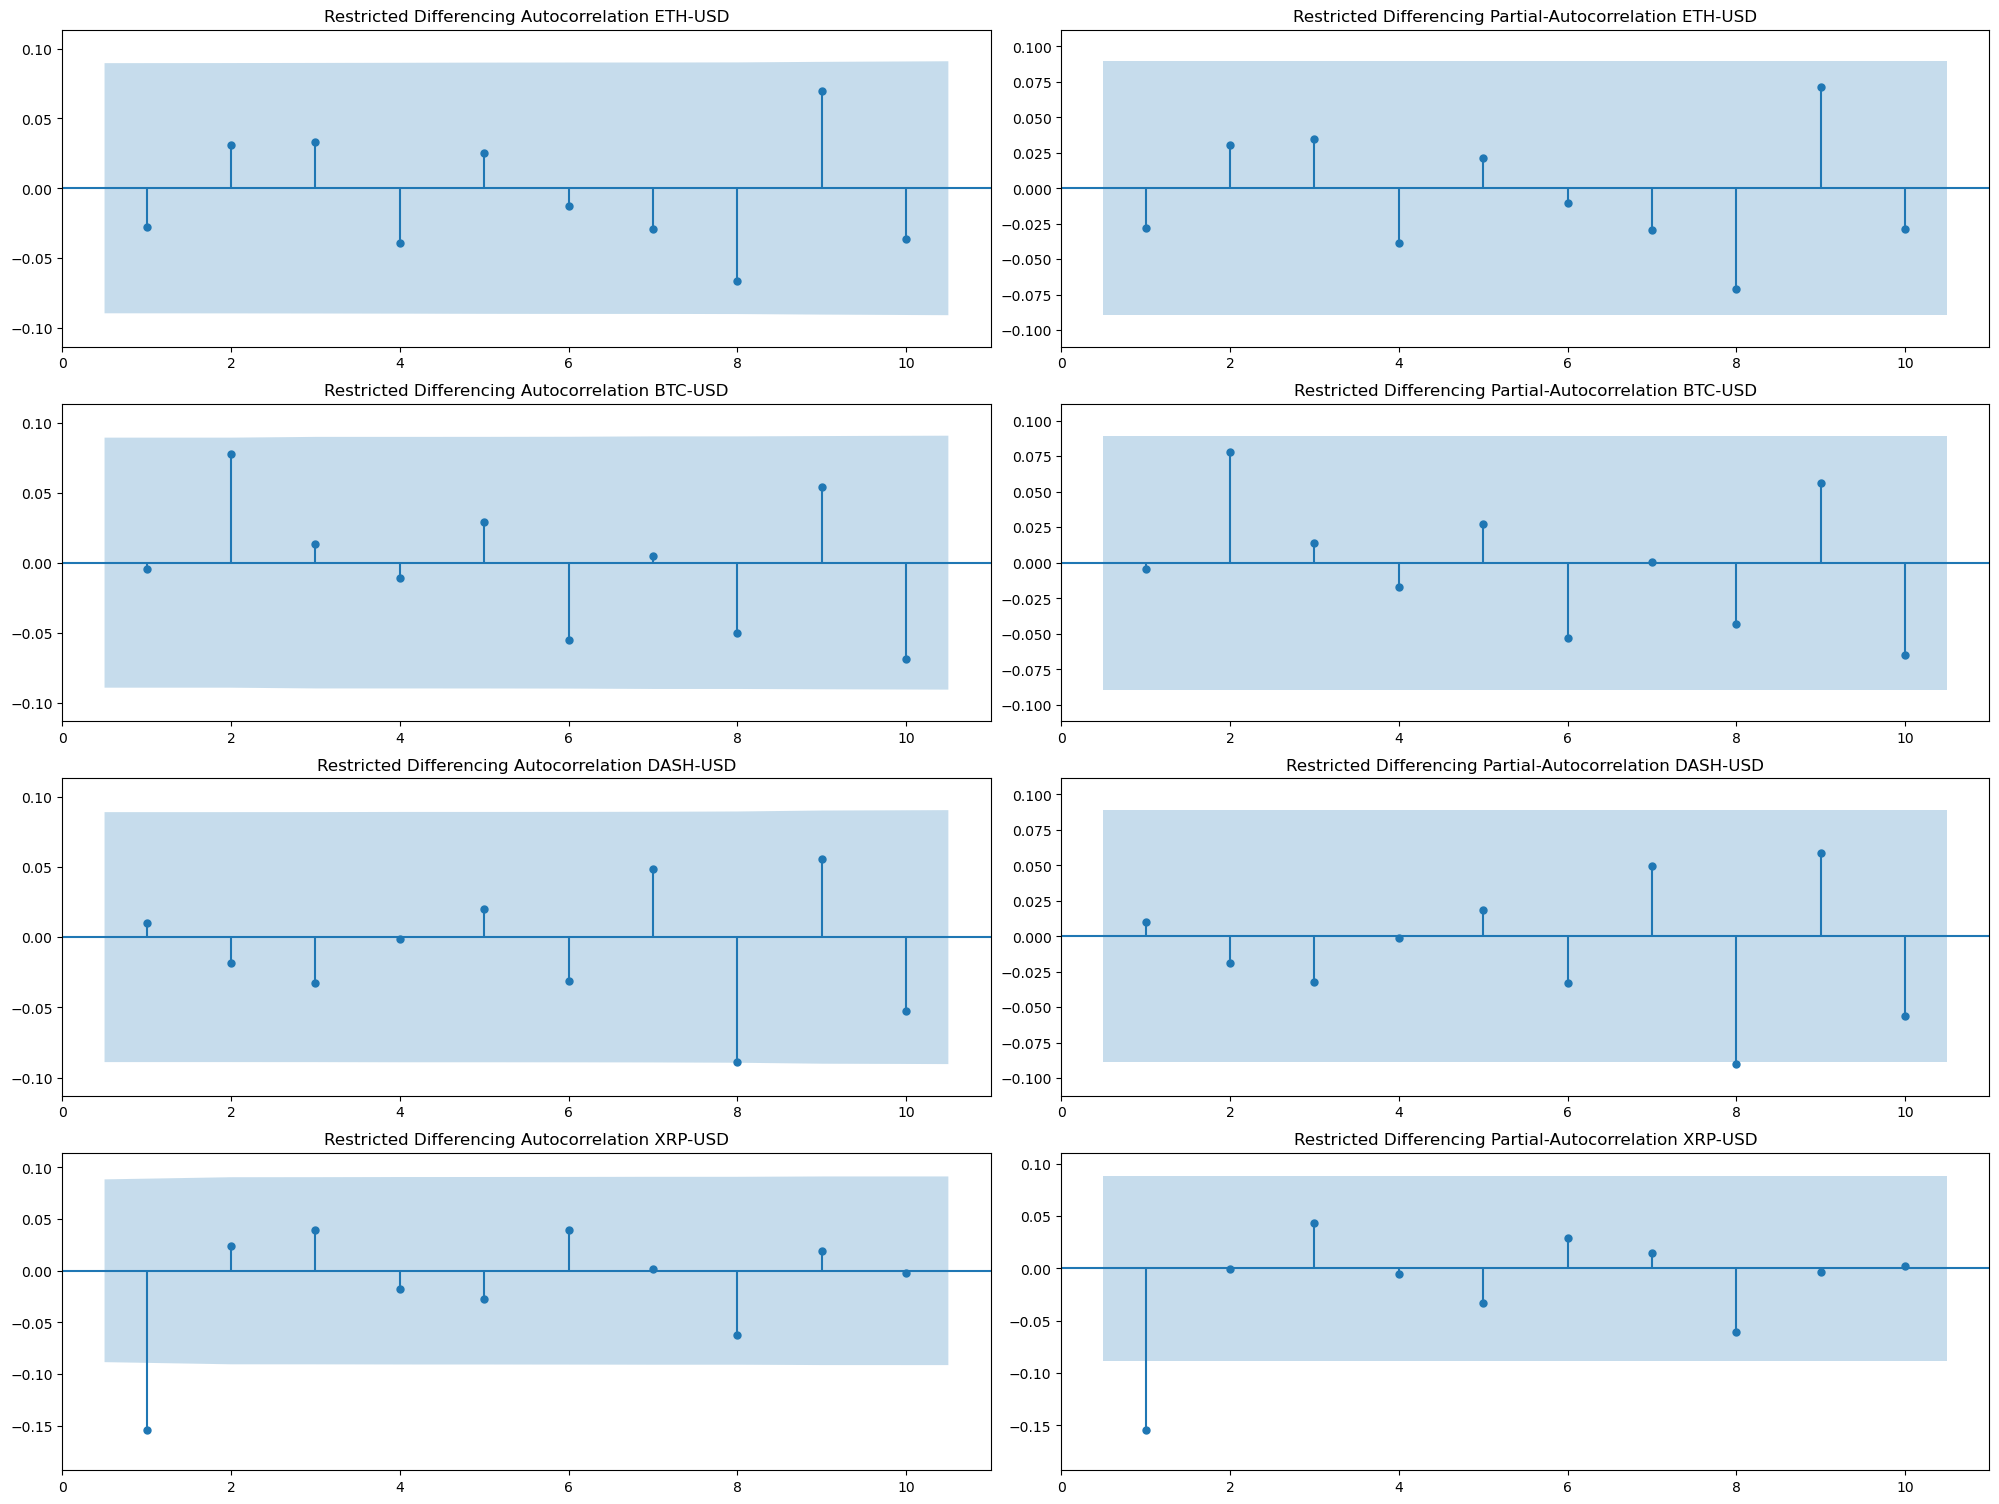

<Figure size 640x480 with 0 Axes>

In [31]:
N_LAGS = 10

fig, ax = plt.subplots(figsize=(20, 15), nrows = len(cryptoList), ncols = 2)
fig.tight_layout(h_pad = 2, w_pad = 2)
i = 0 
for crypto in cryptoList :
    plot_acf(x = restrDiffDataFrameDict[crypto], ax = ax[i][0], lags = N_LAGS, title = "Restricted Differencing Autocorrelation " + crypto, zero = False, auto_ylims = True)
    i += 1

i = 0 
for crypto in cryptoList :
    plot_pacf(x = restrDiffDataFrameDict[crypto], ax = ax[i][1], lags = N_LAGS, title = "Restricted Differencing Partial-Autocorrelation " + crypto, zero = False, auto_ylims = True)
    i += 1

plt.show()
plt.clf()

##### 3_1_4. Analisi Normalità
Per l'analisi di normalità eseguiamo i seguenti test:
* Shapiro-Wilk
* Kolmogorov-Smirnov

Nel test di Shapiro-Wilk abbiamo:
* $H_0$: I dati seguono una distribuzione normale
* $H_1$: I dati NON seguono una distribuzione normale

Nel test di Kolmogorov-Smirnov abbiamo:
* $H_0$: I dati seguono la distribuzione specificata
* $H_1$: I dati NON seguono la distribuzione specificata

Nel nostro caso vogliamo:
* Shapiro-Wilk, **Accettare**
* Kolmogorov-Smirnov, **Accettare**

In [32]:
#%%capture --no-display
SIGNIFICANCE_LEVEL = 0.05

# Esegue il test di normalità di Shapiro-Wilk
shapiroTable = buildTable("Shapiro-Wilk", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList:   
    statValue, pValue = shapiro(restrDiffDataFrameDict[crypto])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    shapiroTable.add_row(crypto, str(statValue), str(pValue), outcomeString)


ksTable = buildTable("Kolmogorov-Smirnov", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList:   
    statValue, pValue = kstest(restrDiffDataFrameDict[crypto], norm.cdf)
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    ksTable.add_row(crypto, str(statValue), str(pValue), outcomeString)

skewKurtTable = buildTable("Skewness & Kurtosis", ["Crypto", "Skew", "Kurt"], ["left", "right", "right"])
for crypto in cryptoList :
    skew = restrDiffDataFrameDict[crypto].skew()
    kurt = restrDiffDataFrameDict[crypto].kurt()
    skewKurtTable.add_row(crypto, str(skew), str(kurt))

console = Console()
console.print(shapiroTable)
console.print(ksTable)
console.print(skewKurtTable)

                            Shapiro-Wilk                            
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.9152018427848816 │    9.5920933210745e-16 │ Reject  │
│ BTC-USD  │ 0.9007473587989807 │ 3.8848841871018364e-17 │ Reject  │
│ DASH-USD │ 0.9368812441825867 │ 1.8093858388575773e-13 │ Reject  │
│ XRP-USD  │  0.759989321231842 │  3.974902468466319e-26 │ Reject  │
└──────────┴────────────────────┴────────────────────────┴─────────┘

                          Kolmogorov-Smirnov                          
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃                  pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  0.4748597924322958 │   1.025490019123565e-99 │ Reject  │
│ BTC-USD  │  0.4823269097938928 │ 1.7161702832698116e-103 │ Reject  │
│ DASH-USD │ 0.47506848329815843 │ 4.7271486293927816e-101 │ Reject  │
│ XRP-USD  │  0.4740511391137273 │  7.825630875049279e-102 │ Reject  │
└──────────┴─────────────────────┴─────────────────────────┴─────────┘

                  Skewness & Kurtosis                  
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Crypto   ┃                 Skew ┃              Kurt ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ETH-USD  │ -0.45071952360275463 │ 5.020392678580047 │
│ BTC-USD  │   -0.706894692667363 │ 6.023639028156162 │
│ DASH-USD │  -0.9443365884359229 │  4.73937272397762 │
│ XRP-USD  │   3.2522634380437023 │ 41.85309753200656 │
└──────────┴──────────────────────┴───────────────────┘

## 4. Divisione del dataset
Dividiamo il dataset in due parti, training e test set: manteniamo nel training circa il 90% dei dati di ogni strumento

In [33]:
trainCryptoDict : dict[str, pd.DataFrame] = {}
testCryptoDict : dict[str, pd.DataFrame] = {}
trainCryptoDiffDict : dict[str, pd.DataFrame] = {}
testCryptoDiffDict : dict[str, pd.DataFrame] = {}

for crypto in cryptoList :
    totalSize = restrCryptoDataFrameDict[crypto].shape[0]
    trainSize = int((totalSize / 100) * 90)
    testSize = totalSize - trainSize

    trainCryptoDict[crypto] = restrCryptoDataFrameDict[crypto].iloc[restrCryptoDataFrameDict[crypto].index < trainSize]
    trainCryptoDict[crypto].reset_index(drop = True, inplace = True)
    testCryptoDict[crypto] = restrCryptoDataFrameDict[crypto].iloc[restrCryptoDataFrameDict[crypto].index >= trainSize]
    testCryptoDict[crypto].reset_index(drop = True, inplace = True)

    trainCryptoDiffDict[crypto] = restrDiffDataFrameDict[crypto].iloc[restrDiffDataFrameDict[crypto].index < trainSize]
    trainCryptoDiffDict[crypto].reset_index(drop = True, inplace = True)
    testCryptoDiffDict[crypto] = restrDiffDataFrameDict[crypto].iloc[restrDiffDataFrameDict[crypto].index >= trainSize]
    testCryptoDiffDict[crypto].reset_index(drop = True, inplace = True)